# Project: Customer Visit Analysis

This notebook aims to do basic customer analysis based on their visit behavior in 4s shop.

If anyone has decided to buy a car, usually they will go to 4s shops to learn more about the desired car models, e.g the performance and safety parameters, price and discount, etc. Sometimes they also request for test drive.

By analyzing their visit behavior, we hope to have better customer insight. The next steps will follow the CRISP-DM process. 

Let's get started... 


## Business Understanding

From business perspective, below are the questions we most care about: 

- How many customers make an order finally?  
- Does customer usually make appointment before they visit the 4s dealer shop,  and prefer to come to a sales consultant for more information. 
- How long does the customer usually stay in the 4s shop?  
- How many customers request for test drive? Is test drive a significant feature to make an order?
- Can we predict he or she will make an order based on the real-time visit behavior data? 
- What are the common features of these customers who purchase the car finally?  And what is the weight for each feature? 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data Understanding

In [2]:
data = pd.read_csv('data/visit_history.csv')
print(data.shape)
print('Total number of data records is: {}'.format(data.shape[0])) 

(318807, 21)
Total number of data records is: 318807


In [3]:
pd.set_option('display.max_columns', 100)
data.head(10)

,first_time_flag,appointment_flag,sc_flag,arrival_time,depart_time,stay_duration,drive_time_f,drive_time_t,drive_duration,drive_model,Intentional_model,current_brand,trail,quote_flag,order_flag,delivery_flag,objective,area_region,area,tier_city,subregion
0,是,否,否,08:46,08:51,5分,NaN,NaN,NaN,NaN,A/B-Class,奔驰,散客,否,否,否,看车比价,East,Ningbo,Tier 1,East 2
1,是,否,SC20,08:08,08:08,0分,NaN,NaN,NaN,NaN,NaN,NaN,散客,NaN,NaN,NaN,办手续,North,Beijing,Tier 1,North 1
2,是,否,否,08:08,08:08,0分,NaN,NaN,NaN,NaN,PbP GLA-Class,NaN,散客,NaN,NaN,NaN,看车比价,North,Beijing,Tier 1,North 1
3,是,否,SC23,08:21,08:24,3分,NaN,NaN,NaN,NaN,NaN,NaN,散客,NaN,NaN,NaN,办手续,North,Beijing,Tier 1,North 1
4,是,否,否,08:25,08:37,12分,NaN,NaN,NaN,NaN,PbP C-Class,NaN,散客,NaN,NaN,NaN,看车比价,North,Beijing,Tier 1,North 1
5,是,否,否,08:46,08:54,8分,NaN,NaN,NaN,NaN,R-Class,NaN,散客,NaN,NaN,NaN,看车比价,North,Beijing,Tier 1,North 1
6,是,否,否,08:54,08:55,1分,NaN,NaN,NaN,NaN,PbP GLA-Class,NaN,散客,NaN,NaN,NaN,看车比价,North,Beijing,Tier 1,North 1
7,是,否,SC13,08:19,08:56,37分,08:20,08:40,20分,PbP GLK-Class,PbP-GLK300,NaN,散客,否,否,否,看车比价,North,Beijing,Tier 1,North 1
8,是,否,008,08:36,08:49,13分,NaN,NaN,NaN,NaN,PbP-C200,NaN,散客,否,否,是,交车,East,Wuxi,Tier 2,East 1
9,是,否,否,08:43,08:54,11分,NaN,NaN,NaN,NaN,PbP GLK-Class,NaN,散客,是,否,否,看车比价,East,Wuxi,Tier 2,East 1


## Prepare Data

### Delete rows that are not relevant to current analysis

There is a important column "objective", we can delete rows directly if the objective is aftersales relevant. 

In [4]:
data.objective.unique()

array(['看车比价', '办手续', '交车', '订单', '其他', '退订', nan, '交车后退车'], dtype=object)

In [5]:
data.objective = data.objective.map({'看车比价': 'Inquire', '订单':'Order', '交车':'Handover' }) 

In [6]:
# Only keep the data with objective "Inquire", "Order" and "Handover"
data = data[(data.objective=='Inquire') | (data.objective=='Order') | (data.objective=='Handover')]

In [7]:
print(data.shape)
print('Total number of data records is: {}'.format(data.shape[0])) 

(294986, 21)
Total number of data records is: 294986


In [8]:
data.groupby(['objective']).size()

objective
Handover     36187
Inquire     223027
Order        35772
dtype: int64

In [9]:
data.first_time_flag.unique()

array(['是', '否'], dtype=object)

In [10]:
data.first_time_flag = data.first_time_flag.map({'是': 'Y', '否':'N'}) 

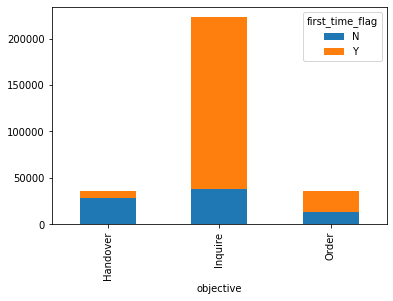

In [11]:
data.groupby(['objective','first_time_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

### Assess Missing Data

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294986 entries, 0 to 318806
Data columns (total 21 columns):
first_time_flag      294986 non-null object
appointment_flag     294986 non-null object
sc_flag              294986 non-null object
arrival_time         294982 non-null object
depart_time          294982 non-null object
stay_duration        294982 non-null object
drive_time_f         57750 non-null object
drive_time_t         57750 non-null object
drive_duration       57750 non-null object
drive_model          57736 non-null object
Intentional_model    294986 non-null object
current_brand        143760 non-null object
trail                294986 non-null object
quote_flag           278217 non-null object
order_flag           278217 non-null object
delivery_flag        278217 non-null object
objective            294986 non-null object
area_region          294986 non-null object
area                 294986 non-null object
tier_city            294986 non-null object
subregion    

In [13]:
print('Total number of missing values is: {}'.format(data.isnull().sum().sum())) 
data.isnull().sum()

Total number of missing values is: 1150539


first_time_flag           0
appointment_flag          0
sc_flag                   0
arrival_time              4
depart_time               4
stay_duration             4
drive_time_f         237236
drive_time_t         237236
drive_duration       237236
drive_model          237250
Intentional_model         0
current_brand        151226
trail                     0
quote_flag            16769
order_flag            16769
delivery_flag         16769
objective                 0
area_region               0
area                      0
tier_city                 0
subregion                36
dtype: int64

In [14]:
def check_missing_pct(df): 
    """
    Check missing value percentage for a dataframe
    """
    missing = df.isnull().sum()
    pct_missing =(missing[missing > 0] / len(df))*100 
    print(pct_missing.sort_values(ascending=False))

In [15]:
#missing = data.isnull().sum()
#pct_missing =(missing[missing > 0] / len(data))*100 
#pct_missing.sort_values(ascending=False)

check_missing_pct(data)

drive_model       80.427546
drive_duration    80.422800
drive_time_t      80.422800
drive_time_f      80.422800
current_brand     51.265484
delivery_flag      5.684677
order_flag         5.684677
quote_flag         5.684677
subregion          0.012204
stay_duration      0.001356
depart_time        0.001356
arrival_time       0.001356
dtype: float64


In [16]:
data.shape

(294986, 21)

Basically the data quality seems good, and there are not too much missing values. 
5.68% of the data is missing “order_flag”, I decide to delete them because I am not able to distinguish whether he/she make order finally.  

In [17]:
data = data[~data.order_flag.isna()]
data.shape
#data.dropna(subset=['order_flag']) //It doesn't work...any wrong?

(278217, 21)

In [18]:
data = data[~data.arrival_time.isna()]
data.shape

(278213, 21)

In [19]:
# Re-check missing value 
check_missing_pct(data)

drive_model       79.276310
drive_duration    79.276310
drive_time_t      79.276310
drive_time_f      79.276310
current_brand     49.847419
subregion          0.012940
dtype: float64


### Feature Transformation

Now we will continue to improve the features and do necessary transformation   
In parallel, we will also try to answer some of the questions we raised at the beginning of the notebook.

Firstly I define a new column "target" as our label Y 

In [20]:
data.order_flag = data.order_flag.apply(lambda x : 1 if x == '是' else 0)
data.delivery_flag = data.delivery_flag.apply(lambda x : 1 if x == '是' else 0)
data['target'] = data.order_flag 

# Merge order_flag and delivery_flag to a target flag
#data['target'] = data.order_flag + data.delivery_flag 
#data.target = data.target.apply(lambda x : 1 if x >= 1 else 0) 

#### Question: How many customers made order finally?

In [21]:
print(data.order_flag.sum()/data.shape[0])

0.16759461276072649


Answer: About 16% of people made order. 

#### Question: Does customer usually make appointment before they visit the 4s dealer shop, and prefer to come to a sales consultant for more information?

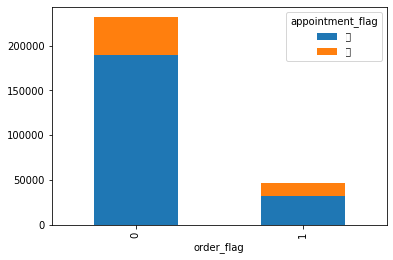

In [22]:
data.groupby(['order_flag','appointment_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [23]:
# Convert appointment_flag to 1/0
data.appointment_flag = data.appointment_flag.replace(['是', '否'], [1, 0])

In [24]:
# Convert sc_flag to 1/0 
data.sc_flag = data.sc_flag.apply(lambda x : 0 if x == '否' else 1)

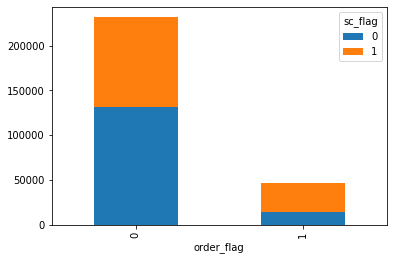

In [25]:
data.groupby(['order_flag','sc_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

Answer: From the charts above, we see whether he/she make an appointment does not bring positive effect. But if there is a sales consultant assigned, the possibility to order will be significantly improved.


#### Question: How long does the customer usually stay in the 4s shop?

In [26]:
# Convert stay_duration to mins
data.stay_duration = data.stay_duration.apply(lambda x: int(x.replace('分', '')))
# Delete outliers of stay_duration
data = data[data.stay_duration > 0] 

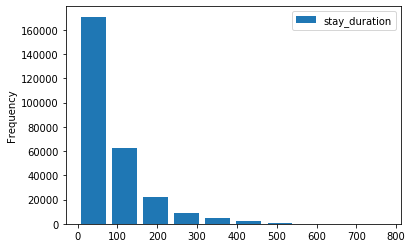

In [27]:
data[['stay_duration']].plot(kind='hist',rwidth=0.8)
plt.show()

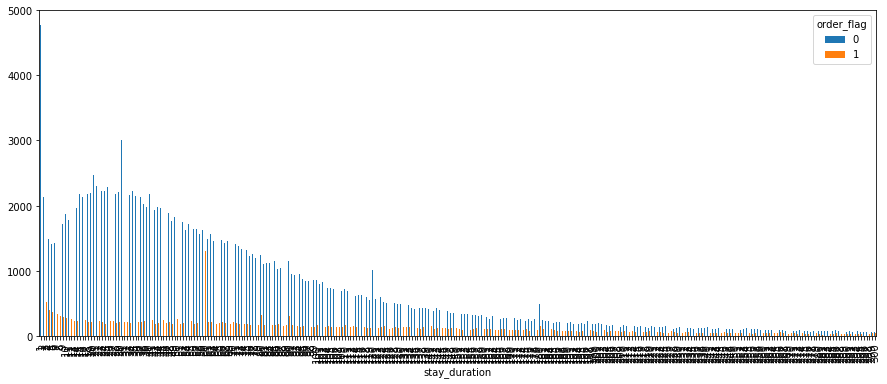

In [28]:
data[data.stay_duration<=300].groupby(['stay_duration','order_flag']).size().unstack().plot(kind='bar',figsize=(15,6))
plt.show()

In [29]:
data['stay_duration'].mean()

83.16200628893853

Answer: The average time each customer usually stay in the 4s shop is 83 minutes, and almost of them stay in less one hour. we can also have a distribution overview from the charts above.

Next, we divide the stay duration into different interval segments for futher analysis 

In [30]:
temp_stay_duration_band = []

for duration_mins in data['stay_duration']:
    if (duration_mins <= 60):
        temp_stay_duration_band.append(0)
    elif (duration_mins > 60) & (duration_mins <= 80):
        temp_stay_duration_band.append(1)
    elif (duration_mins > 80) & (duration_mins <= 100):
        temp_stay_duration_band.append(2)
    elif (duration_mins > 100) & (duration_mins <= 120):
        temp_stay_duration_band.append(3)
    else:
        temp_stay_duration_band.append(4)

data['stay_duration_band'] = temp_stay_duration_band

#### Question: What is the distribution of arrival_time?

In [31]:
# Create field of arrival_period, 1 as normal working hour, 0 as non working hour
data['period'] = data.arrival_time.str.extract('([0-9]+)\:', expand=False).astype(int)
data['arrival_period'] = 0
data.loc[(data.period >= 8) & (data.period <= 21), 'arrival_period'] = 1
data.loc[(data.period <  8) | (data.period >  21), 'arrival_period'] = 0

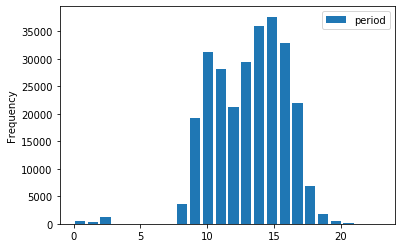

In [32]:
data[['period']].plot(kind='hist', bins=24, rwidth=0.8)
plt.show()

#### Question: How many customers request for test drive? Is test drive a significant feature to make an order?  

In [33]:
# Create test_drive_flag 1:Yes, 0:No
data['test_drive_flag'] = 0
data.loc[data.drive_duration.notnull(), 'test_drive_flag'] = 1

In [34]:
print(data.test_drive_flag.sum()/data.shape[0])

0.21017250499588574


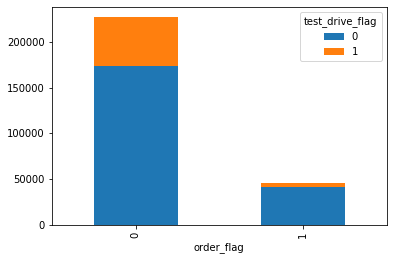

In [35]:
data.groupby(['order_flag','test_drive_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

Answer: 21% of people have applied for test drive. But I am a little bit surprised that people who applied test drive has lower possibility to make an order.

In [36]:
# Translate trail to english, and then convert it to one-hot features
data.trail = data.trail.map( {'主动集客': 'group-buying', 
                              '休眠': 'inactive', 
                              '再购': 'buyagain', 
                              '呼入': 'callin', 
                              '推荐': 'recommend', 
                              '散客': 'independent', 
                              '活跃': 'active', 
                              '网络': 'internet'} )
data = pd.get_dummies(data, columns=['trail'])

In [37]:
# Convert quote_flag to 1/0
data.quote_flag = data.quote_flag.replace(['是', '否'], [1, 0])
data.quote_flag = data.quote_flag.fillna(0)

In [38]:
# Convert first_time_flag to 1/0
data.first_time_flag = data.first_time_flag.replace(['Y', 'N'], [1, 0])

In [39]:
# Convert tier_city to sequence feature
data.tier_city = data.tier_city.map( {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3, 'Tier 4': 4} ).astype(int)

In [40]:
# Convert subregion to one-hot features
data = pd.get_dummies(data, columns=['subregion'])

It's not easy to classify their current car brand... To make it simple I create a new fueature brand_flag

In [41]:
data['brand_flag'] = data.current_brand.apply(lambda x : 0 if str(x)=='nan' else 1)

In [42]:
data.columns

Index(['first_time_flag', 'appointment_flag', 'sc_flag', 'arrival_time',
       'depart_time', 'stay_duration', 'drive_time_f', 'drive_time_t',
       'drive_duration', 'drive_model', 'Intentional_model', 'current_brand',
       'quote_flag', 'order_flag', 'delivery_flag', 'objective', 'area_region',
       'area', 'tier_city', 'target', 'stay_duration_band', 'period',
       'arrival_period', 'test_drive_flag', 'trail_active', 'trail_buyagain',
       'trail_callin', 'trail_group-buying', 'trail_inactive',
       'trail_independent', 'trail_internet', 'trail_recommend',
       'subregion_East 1', 'subregion_East 2', 'subregion_North 1',
       'subregion_North 2', 'subregion_North 3', 'subregion_South 1',
       'subregion_South 2', 'subregion_West', 'brand_flag'],
      dtype='object')

In [43]:
# delete the columns which we will not use any more
final_df = data.drop(['arrival_time',
                      'depart_time',
                      'drive_time_f',
                      'drive_time_t',
                      'drive_model',
                      'Intentional_model',
                      'current_brand',
                      'quote_flag', 
                      'order_flag',
                      'delivery_flag',
                      'period',
                      'objective',
                      'area_region',
                      'area',
                      'stay_duration',
                      'drive_duration'], axis=1)

In [44]:
final_df.head(10)

,first_time_flag,appointment_flag,sc_flag,tier_city,target,stay_duration_band,arrival_period,test_drive_flag,trail_active,trail_buyagain,trail_callin,trail_group-buying,trail_inactive,trail_independent,trail_internet,trail_recommend,subregion_East 1,subregion_East 2,subregion_North 1,subregion_North 2,subregion_North 3,subregion_South 1,subregion_South 2,subregion_West,brand_flag
0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
7,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
8,1,0,1,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
9,1,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
10,1,0,0,3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
11,0,0,1,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
12,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
14,1,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
15,0,1,1,2,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
16,0,0,1,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


### Short conclusion of Data perparation
- In this step I firstly delete the data with missing `order_flag` and `arrival_time`, because they are important features from business perspective, and the missing rate in very low, so it's Ok to delete them directly.
- Then I replaced the binary categorical features with values of 0 and 1.
- For multi-level categorical features, I decide to used pd.get_dummies to encode them to OneHot features, since it will not increase the total column number too much. 
- For time related features, I divided them into different interval segments for further analysis.
- And for the complicated feature (e.g. current_brand), it's not easy to classify the brands, I decide to make it simple to just create a new 1/0 flag.  

## Data Modeling

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics
from sklearn.externals import joblib

In [46]:
X = final_df.drop(['target'],axis=1).as_matrix()
y = final_df['target'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)

(190556, 24)
(81668, 24)


In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_predprob_lr = logreg.predict_proba(X_test)[:,1]
acc_log = round(accuracy_score(y_test, y_pred_lr) * 100, 2)
print(acc_log)
print(classification_report(y_test, y_pred_lr))

83.88
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     67864
           1       0.74      0.07      0.13     13804

   micro avg       0.84      0.84      0.84     81668
   macro avg       0.79      0.53      0.52     81668
weighted avg       0.82      0.84      0.78     81668



In [48]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
y_predprob_rf = random_forest.predict_proba(X_test)[:,1]
acc_rf = round(accuracy_score(y_test, y_pred_rf) * 100, 2)
print(acc_rf)
print(classification_report(y_test, y_pred_rf))

83.86
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     67864
           1       0.58      0.16      0.25     13804

   micro avg       0.84      0.84      0.84     81668
   macro avg       0.72      0.57      0.58     81668
weighted avg       0.81      0.84      0.80     81668



## Evaluate the Results

#### Question: Can we predict he or she will make an order based on the real-time visit behavior data?
Answer: Yes we can predict using the model above, and the performance looks fine. But the major objective of this notebook is not to build such model, so I do not decide to take much time to refine it.  

### Extracting Feature Importance

#### Question: What are the common features of these customers who purchase the car finally? And what is the weight for each feature? 

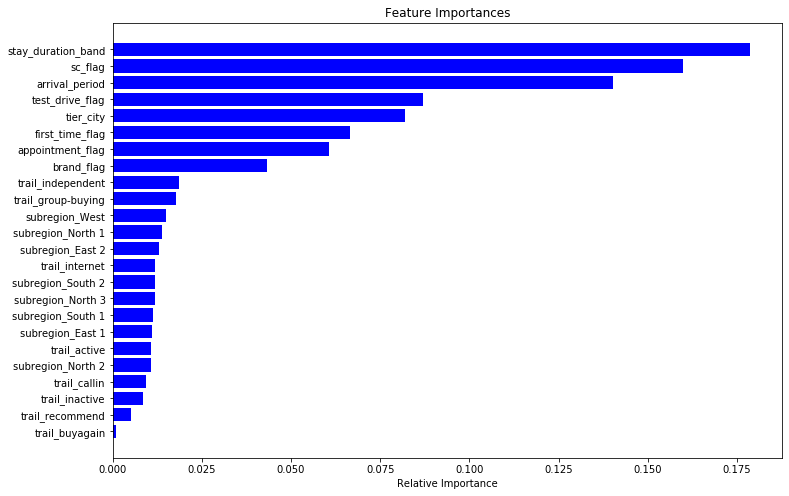

In [49]:
df = final_df.drop(['target'],axis=1)
features = df.columns[:df.shape[1]]
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');